# Function Testing Notebook - Joseph

This notebook is meant to test external-facing functions to ensure they are working as expected.

A dedicated test_all_functions.py with unit testing might be better, but this is a good benchmark

In [3]:
import os
import sys
from pathlib import Path
import time
import tempfile
import logging

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mne
from dask_jobqueue import SLURMCluster
from dask.distributed import Client

In [4]:
# packageroot = Path('../../').resolve()
packageroot = Path('/Users/ohy2/Documents/GitHubRepo/PyEEG').resolve()
print(packageroot)
sys.path.append(str(packageroot))

from pythoneeg import core
from pythoneeg import visualization
# from pythoneeg import constants

print(core.__all__)
# print(visualization.__all__)
# print(dir(constants))

/Users/ohy2/Documents/GitHubRepo/PyEEG


/Users/ohy2/Documents/GitHubRepo/PyEEG/.venv_mouseEEG/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['DDFBinaryMetadata', 'LongRecordingOrganizer', 'convert_ddfcolbin_to_ddfrowbin', 'convert_ddfrowbin_to_si', 'convert_units_to_multiplier', 'convert_colpath_to_rowpath', 'filepath_to_index', 'is_day', 'set_temp_directory', 'get_temp_directory', 'LongRecordingAnalyzer', 'MountainSortAnalyzer', 'FragmentAnalyzer']


In [3]:
core.set_temp_directory('/scr1/users/dongjp')

In [ ]:
tmpmet = core.DDFBinaryMetadata(r"/mnt/isilon/marsh_single_unit/PythonEEG Data Bins/A5 WT 12_12-2023/Cage 1 A5 -1_Meta.csv")
print(tmpmet.dt_end.ctime())
display(tmpmet.channel_names)

In [5]:
data_folder = Path('./test-data').resolve()
lrec = core.LongRecordingOrganizer(base_folder_path= data_folder / 'A10 KO 12_13_2023',
                                    truncate=3)
lrec.convert_colbins_to_rowbins(overwrite=False)
lrec.convert_rowbins_to_rec()

/home/dongjp/source-code/PyEEG/pythoneeg/core/core.py:153: UserWarning: truncate = True. Only the first 3 files of each animal will be used
  warnings.warn(f"truncate = True. Only the first {self.n_truncate} files of each animal will be used")


In [6]:
Path('./test-wars/A5').resolve()

PosixPath('/home/dongjp/source-code/PyEEG/notebooks/tests/test-wars/A5')

In [7]:
# cluster_window = SLURMCluster(
#         cores=8,
#         memory='20GB',
#         walltime='12:00:00',
#         interface=None,
#         scheduler_options={'interface': 'eth1'},
#         job_extra_directives=['--output=/dev/null',
#                              '--error=/dev/null']
#     )
# cluster_window.scale(jobs=15)  # Scale to 16 workers
# display(cluster_window)
# cluster_window.wait_for_workers(15)

In [ ]:
cluster_spike = SLURMCluster(
        cores=1,
        memory='10GB',
        processes=1,
        walltime='12:00:00',
        interface=None,
        scheduler_options={'interface': 'eth1'},
        job_extra_directives=['--output=/dev/null',
                             '--error=/dev/null']
    )
cluster_spike.scale(10)
display(cluster_spike)
cluster_spike.wait_for_workers(10)

In [9]:
# Set up logger with detailed formatting
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG, stream=sys.stdout, force=True)
logger = logging.getLogger()


In [ ]:
# %%script true
# animal_ids = ['A5', 'A10', 'F22', 'G25']
# animal_ids = ['A5']
animal_ids = ['A10']
# animal_ids = ['F22']
# animal_ids = ['G25']
base_folder = Path('./test-data').resolve()
# base_folder = Path('/mnt/isilon/marsh_single_unit/PythonEEG Data Bins').resolve()
for animal_id in animal_ids:
    ao = visualization.AnimalOrganizer(base_folder, animal_id, mode="concat", assume_from_number=True, truncate=False)
    ao.convert_colbins_to_rowbins(overwrite=False)
    ao.convert_rowbins_to_rec() # paralleization breaks if not enough memory

    # with Client(cluster_window) as client:
    #     client.upload_file(str(packageroot / 'pythoneeg.zip'))
    #     display(client)
    #     print("running war")
    #     war = ao.compute_windowed_analysis(['all'], exclude=['nspike', 'wavetemp'], multiprocess_mode='dask')
    #     war.to_pickle_and_json(Path(f'./test-wars/{animal_id}').resolve())

    with Client(cluster_spike) as client:
        client.upload_file(str(packageroot / 'pythoneeg.zip'))
        display(client)
        print("running sar")
        sar = ao.compute_spike_analysis(multiprocess_mode='dask')

In [ ]:
war = visualization.WindowAnalysisResult.load_pickle_and_json(Path('./test-wars/F22').resolve())

In [ ]:
war.get_result(['all'], allow_missing=True).head(3)

In [ ]:
logger.setLevel(logging.WARNING)
ap = visualization.AnimalPlotter(war)
ap.plot_coherecorr_matrix(['isday'], bands=None, figsize=(16,5), cmap='viridis')
# ap.plot_coherecorr_diff(['isday'], bands=None, figsize=(16,5))
# ap.plot_linear_temporal(figsize=(20, 5), score_type='z', lw=1, channels=[0, 1])
# ap.plot_linear_temporal(['isday'], figsize=(20, 5), score_type='z', lw=1, channels=[0, 1, 2, 3])

# ap.plot_coherecorr_spectral(['isday'], figsize=(20, 5), score_type='center')

ap.plot_coherecorr_spectral(figsize=(20, 5), score_type='center')
ap.plot_psd_histogram(figsize=(10, 4), avg_channels=True, plot_type='loglog')
ap.plot_psd_spectrogram(figsize=(20, 4), mode='none')

In [ ]:
wars = []
animal_ids = ['A10', 'F22']
for animal_id in animal_ids:
    wars.append(visualization.WindowAnalysisResult.load_pickle_and_json(Path(f'./test-wars/{animal_id}').resolve()))
ep = visualization.ExperimentPlotter(wars)
ep.plot_boxplot('rms')
ep.plot_violin('rms')
ep.plot_scatter('rms')

In [15]:
logger.setLevel(logging.DEBUG)

In [ ]:
for e in sar:
    e.convert_to_mne(chunk_len=1440)
    e.save_fif_and_json(Path(f'./test-mnes/{e.animal_day}').resolve(), overwrite=True)

In [5]:
reconstruct_sas = visualization.SpikeAnalysisResult.load_fif_and_json('./test-mnes/A5 WT Dec-12-2023')
mne_obj = reconstruct_sas.result_mne

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/isilon/marsh_single_unit/PythonEEG Data Bins/A5 WT 12_12-2023/Cage 1 A5 -1_Meta.csv'

Used Annotations descriptions: [np.str_('Intan Input (1)/PortB L Aud Ctx'), np.str_('Intan Input (1)/PortB L Barrel'), np.str_('Intan Input (1)/PortB L Hipp'), np.str_('Intan Input (1)/PortB L Motor'), np.str_('Intan Input (1)/PortB L Vis Ctx'), np.str_('Intan Input (1)/PortB R Aud Ctx'), np.str_('Intan Input (1)/PortB R Barrel'), np.str_('Intan Input (1)/PortB R Hipp'), np.str_('Intan Input (1)/PortB R Motor'), np.str_('Intan Input (1)/PortB R Vis Ctx')]


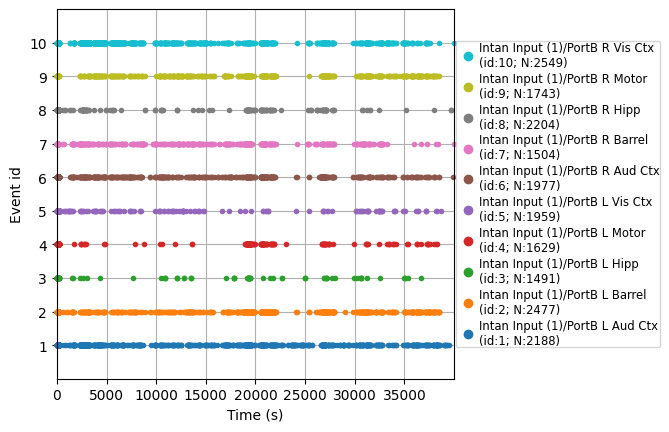

In [18]:
logger.setLevel(logging.WARNING)
events, event_id = mne.events_from_annotations(raw=mne_obj)
fig = mne.viz.plot_events(events, sfreq=mne_obj.info['sfreq'], first_samp=mne_obj.first_samp, event_id=event_id)

In [19]:
# quick hack to look at peri-spike EEG

def analyze_peri_spike_tfr(mne_obj: mne.io.Raw, tmin=-3, tmax=3, l_freq=1, h_freq=50):
    """
    Analyze time-frequency representation around spikes from an MNE object.
    
    Parameters:
    -----------
    mne_obj : mne.io.Raw
        The MNE object containing the data and spike annotations
    tmin : float
        Start time relative to spike (in seconds)
    tmax : float
        End time relative to spike (in seconds)
    l_freq : float
        Lower frequency bound for filtering
    h_freq : float
        Upper frequency bound for filtering
    """
    raw = mne_obj.copy()
    events, event_dict = mne.events_from_annotations(raw=raw)
    logging.debug(f"Events: {events}")
    logging.debug(f"Event dict: {event_dict}")
    
    # Common parameters for epoch creation
    epoch_params = {
        'raw': raw,
        'preload': True,
        'baseline': None,
        'event_repeated': 'drop'
    }
    
    # Process each spike type separately
    for unit_id in event_dict.keys():
        print(f"Processing unit: {unit_id}")
        
        # Create spike-centered epochs
        epochs_spike = mne.Epochs(
            **epoch_params,
            event_id={unit_id: event_dict[unit_id]},
            tmin=tmin,
            tmax=tmax
        )
        epochs_spike.filter(l_freq=l_freq, h_freq=h_freq)
        
        # Create baseline epochs from whole recording
        epochs_baseline = mne.make_fixed_length_epochs(
            raw, 
            duration=tmax-tmin,
            preload=True
        )
        epochs_baseline.filter(l_freq=l_freq, h_freq=h_freq)
        
        # Ensure we have comparable numbers of epochs
        n_epochs = min(len(epochs_spike), len(epochs_baseline))
        if n_epochs < 1:
            print(f"No valid epochs for unit {unit_id}")
            continue
            
        epochs_spike = epochs_spike[:n_epochs]
        epochs_baseline = epochs_baseline[:n_epochs]
        
        # Compute time-frequency representation
        tfr_params = dict(
            freqs=np.arange(l_freq, h_freq, 1),
            n_cycles=np.arange(l_freq, h_freq, 1) * 2,
            method='multitaper',
            use_fft=True,
            average=True
        )
        
        print("Computing TFR...")
        tfr_spike = epochs_spike.compute_tfr(**tfr_params)
        tfr_baseline = epochs_baseline.compute_tfr(**tfr_params)
        
        # Plot the results
        plot_tfr_difference(tfr_spike, tfr_baseline)

def plot_tfr_difference(tfr_spike, tfr_baseline):
    """Plot the ratio between spike and baseline TFR."""
    pow_baseline = np.mean(tfr_baseline.get_data(), axis=(0, 2))
    pow_baseline = pow_baseline[:, np.newaxis]
    pow_spike, plot_t, plot_f = tfr_spike.get_data(return_times=True, return_freqs=True)
    pow_spike = np.mean(pow_spike, axis=0)
    pow_ratio = pow_spike - pow_baseline
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 4))
    im = ax.imshow(pow_ratio, aspect='auto',
                   extent=[plot_t[0], plot_t[-1], plot_f[0], plot_f[-1]],
                   origin='lower',
                   cmap=plt.cm.RdBu_r,
                   norm=colors.CenteredNorm())
                #    norm=colors.TwoSlopeNorm(vmin=0.5, vcenter=1, vmax=10))
    
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')
    ax.axvline(0, color='black', linestyle='--')
    plt.colorbar(im, ax=ax, label='Power Ratio (spike/baseline)')
    plt.show()


In [ ]:
# display(mne_obj)
analyze_peri_spike_tfr(mne_obj)